In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
from sklearn.preprocessing import StandardScaler

import datetime
import utils

In [2]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    df['Date'] = df['Date'].apply(utils.convert_time)
    
    df['Latitude'] = df['Latitude'].apply(utils.convert_coords)
    df['Longitude'] = df['Longitude'].apply(utils.convert_coords)
    return df

In [3]:
'''
Takes in a pandas dataframe of hurricane data and:
(1) Change the record identifier column into 1 if hurricane made Landfall (L), else 0
(2) adjust the date column into 3 separate columns - month, day, year. Drops date column.
(3) Imputes missing values with the mean of the column of the truncated data
(4) Standardize data for columns of continuous variables
'''

def prep_hurricane_data(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)

    
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['Latitude', 'Longitude']:
            df[column] = pd.to_numeric(df[column]) # turn every column (except lat/long) into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column

    return df

In [4]:
df = clean_file('hurdat2.txt')
# df = prep_hurricane_data(df)
df

,ID,Date,Time,Record,Status,Latitude,Longitude,Wind speed,Pressure,34NE,...,34SW,34NW,50NE,50SE,50SW,50NW,64NE,64SE,64SW,64NW
0,AL011851,1851-06-25 00:00:00,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,1851-06-25 00:00:00,0600,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,1851-06-25 00:00:00,1200,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,1851-06-25 00:00:00,1800,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,1851-06-25 00:00:00,2100,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,2019-11-26 00:00:00,1200,,EX,52.2,-9.3,45,970,90,...,120,90,0,0,0,0,0,0,0,0
51836,AL202019,2019-11-26 00:00:00,1800,,EX,52.2,-8.9,40,972,90,...,90,90,0,0,0,0,0,0,0,0
51837,AL202019,2019-11-27 00:00:00,0000,,EX,51.8,-8.2,40,974,0,...,90,0,0,0,0,0,0,0,0,0
51838,AL202019,2019-11-27 00:00:00,0600,,EX,51.4,-6.0,40,976,0,...,90,0,0,0,0,0,0,0,0,0


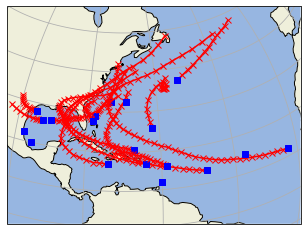

In [5]:
hurricane_IDs = df['ID'].unique()
ax = utils.create_geoaxes()

for ID in hurricane_IDs[0:20]:
    utils.plot_hurricane_trajectory(df, ID, ax=ax)

## Part 1: Predicting whether or not a hurricane will make landfall

Since the records in our hurricane dataset contain *timestamps* of specific hurricanes, it will be more useful to create a dataframe which contains key features of each individual hurricane's track. However, 

In [5]:
# Create dataframe of each individual hurricane
hurricane_IDs = df['ID'].unique()
hurricane_df = pd.DataFrame.from_dict({'ID':hurricane_IDs})
columns = ['Duration', 'Initial latitude', 'Initial longitude',
           'Makes landfall', 'Landfall latitude', 'Landfall longitude']
hurricane_df = hurricane_df.set_index(['ID'])

# Set hurricane data columns
for col in columns:
    hurricane_df[col] = None

for ID in hurricane_IDs:
    attrs = utils.get_hurricane_attributes(df, ID)
    for col in attrs:
        hurricane_df.at[ID, col] = attrs[col]
hurricane_df

,Duration,Initial latitude,Initial longitude,Makes landfall,Landfall latitude,Landfall longitude
ID,,,,,,
AL011851,14,28,-94.8,1,28.2,-96.8
AL021851,1,22.2,-97.6,0,NaN,NaN
AL031851,1,12,-60,0,NaN,NaN
AL041851,49,13.4,-48,1,30.1,-85.7
AL051851,16,32.5,-73.5,0,NaN,NaN
...,...,...,...,...,...,...
AL162019,15,22.2,-95.7,0,NaN,NaN
AL172019,10,24.7,-94.8,0,NaN,NaN
AL182019,22,40,-38.3,0,NaN,NaN


What percent of hurricanes actually make landfall?

In [7]:
sum(hurricane_df['Makes landfall'])/len(hurricane_df)

0.34231378763866877

So, we see that roughly a third of all atlantic tropical cyclones make landfall. But the code below shows that the probability of landfall strongly depends on the genesis coordinate of the cyclone. This is because, not only are more westerly coordinates simply closer to land and thus likelier to be hit, but also due to the different dynamical regimes that partition the Atlantic ocean.

In [6]:
lons = np.arange(-90, -10, 10)
for i in range(len(lons) - 1):
    lonW = lons[i]
    lonE = lons[i+1]
    subset = hurricane_df[(hurricane_df['Initial longitude'] >= lonW) & (hurricane_df['Initial longitude'] < lonE)]
    pct_landfalling = sum(subset['Makes landfall'])/len(subset)
    print('Percent of cyclones starting between longitudes', lonW, 'and', lonE, 'making landfall:',
          '{:.3}'.format(pct_landfalling))

Percent of cyclones starting between longitudes -90 and -80 making landfall: 0.564
Percent of cyclones starting between longitudes -80 and -70 making landfall: 0.374
Percent of cyclones starting between longitudes -70 and -60 making landfall: 0.242
Percent of cyclones starting between longitudes -60 and -50 making landfall: 0.266
Percent of cyclones starting between longitudes -50 and -40 making landfall: 0.158
Percent of cyclones starting between longitudes -40 and -30 making landfall: 0.138
Percent of cyclones starting between longitudes -30 and -20 making landfall: 0.148


In [7]:
lats = np.arange(0, 50, 10)
for i in range(len(lats) - 1):
    latS = lats[i]
    latN = lats[i+1]
    subset = hurricane_df[(hurricane_df['Initial latitude'] >= latS) & (hurricane_df['Initial latitude'] < latN)]
    pct_landfalling = sum(subset['Makes landfall'])/len(subset)
    print('Percent of cyclones starting between longitudes', latS, 'and', latN, 'making landfall:',
          '{:.3}'.format(pct_landfalling))

Percent of cyclones starting between longitudes 0 and 10 making landfall: 0.312
Percent of cyclones starting between longitudes 10 and 20 making landfall: 0.346
Percent of cyclones starting between longitudes 20 and 30 making landfall: 0.405
Percent of cyclones starting between longitudes 30 and 40 making landfall: 0.131


To better categorize the dynamical regimes where the cyclones start, we use k-means clustering on the initial coordinates.

In [8]:
k = 3
p = 2

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=k, p=p)
neigh.fit(hurricane_df[['Initial latitude', 'Initial longitude']])

neigh

NearestNeighbors(n_neighbors=3)

In [9]:
neigh.kneighbors(hurricane_df[['Initial latitude', 'Initial longitude']].iloc[0:10])

(array([[0.        , 0.53851648, 0.72801099],
        [0.        , 0.28284271, 0.4       ],
        [0.        , 0.        , 0.31622777],
        [0.        , 0.3       , 0.4472136 ],
        [0.        , 0.        , 0.28284271],
        [0.        , 0.1       , 0.53851648],
        [0.        , 0.53851648, 0.70710678],
        [0.        , 0.92195445, 1.39283883],
        [0.        , 0.41231056, 0.5       ],
        [0.        , 0.2236068 , 0.36055513]]),
 array([[   0, 1573, 1690],
        [   1, 1794, 1850],
        [  12,    2,  278],
        [   3,  545, 1414],
        [   4,   37, 1674],
        [   5, 1381,   64],
        [   6,  395,  233],
        [   7, 1577,  109],
        [   8, 1238,  141],
        [   9,  356,  759]], dtype=int64))

In [10]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5], [1, 1, 1], [.2, .5, .2]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)

print(neigh.kneighbors([[1., 1., 1.]]))

(array([[0.]]), array([[3]], dtype=int64))


# Correlation matrix

In [11]:
def hurr_quadrants(df):
    df.drop(['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'Wind speed','Pressure'],
            1, inplace=True)
    for column in df:
        df[column] = pd.to_numeric(df[column])
        df[column].replace([-999, 0], np.nan, inplace=True)
    return df

<AxesSubplot:>

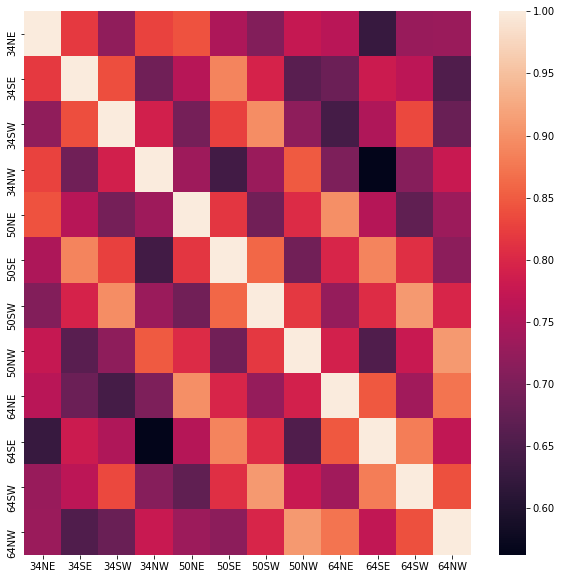

In [12]:
import seaborn as sns

df1 = clean_file('hurdat2.txt')
df_q = hurr_quadrants(df1)
corr = df_q.corr()

plt.figure(figsize=(10,10))  
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

# Hurricane Genesis Points

# Linear Regression

In [13]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file2(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    return df

In [14]:
'''
Takes in a pandas dataframe of hurricane data and:
(1) Change the record identifier column into 1 if hurricane made Landfall (L), else 0
(2) adjust the date column into 3 separate columns - month, day, year. Drops date column.
(3) Imputes missing values with the mean of the column of the truncated data
(4) Standardize data for columns of continuous variables
'''
def prep_hurricane_data2(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    #df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)
    
    # Strip characters (N, E, S, W) from lat/long
    #df['Latitude'] = df['Latitude'].map(lambda x: x.rstrip('NS'))
    #df['Longitude'] = df['Longitude'].map(lambda x: x.rstrip('EW'))
    df['Latitude'] = df.apply(lambda row: float(row.Latitude.rstrip('N')) if ('N' in row.Latitude) 
                              else float(row.Latitude.rstrip('S'))*-1, axis = 1)
    df['Longitude'] = df.apply(lambda row: float(row.Longitude.rstrip('E')) if ('E' in row.Longitude) 
                              else float(row.Longitude.rstrip('W'))*-1, axis = 1)
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['ID']:
            df[column] = pd.to_numeric(df[column]) # turn every column into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column
            
    
    # standardize the variables (4)
#     tv_temp1 = df['Latitude'] # temporary variable for target variables
#     tv_temp2 = df['Longitude']
#     tv_temp3 = df['ID']
#     scaler = StandardScaler()
#     scaler.fit(df.drop(['Latitude','Longitude','ID'], axis=1))
#     df = pd.DataFrame(scaler.transform(df.drop(['Latitude','Longitude','ID'], axis=1)), 
#                       columns = df.drop(['Latitude','Longitude','ID'], axis=1).columns)
#     df['Latitude'] = tv_temp1
#     df['Longitude'] = tv_temp2
#     df['ID'] = tv_temp3
    return df

In [15]:
df1 = clean_file2('hurdat2.txt')
df1_1 = prep_hurricane_data2(df1)
df1_1

,ID,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
0,AL011851,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
1,AL011851,600,0,28.0,-95.4,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
2,AL011851,1200,0,28.0,-96.0,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
3,AL011851,1800,0,28.1,-96.5,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
4,AL011851,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,1200,0,52.2,-9.3,45,970.000000,90.000000,240.000000,120.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51836,AL202019,1800,0,52.2,-8.9,40,972.000000,90.000000,240.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51837,AL202019,0,0,51.8,-8.2,40,974.000000,0.000000,210.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27
51838,AL202019,600,0,51.4,-6.0,40,976.000000,0.000000,180.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27


In [16]:
genesis_df = df1_1.groupby('ID').first()  # get the starting (genesis) row of each unique hurricane
BBox = (genesis_df.Longitude.min(),   genesis_df.Longitude.max(),      
         genesis_df.Latitude.min(), genesis_df.Latitude.max())  # define a bounding box that includes all genesis data
genesis_df

,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,34NW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
ID,,,,,,,,,,,,,,,,,,,,,
AL011851,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
AL011852,0,0,20.5,-67.1,60,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1852,8,19
AL011853,1200,0,32.5,-69.0,50,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1853,8,5
AL011854,0,0,26.0,-92.5,60,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1854,6,25
AL011855,1200,0,22.2,-98.0,90,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1855,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL282005,0,0,13.2,-62.1,30,1007.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2005,11,14
AL291969,1200,0,10.3,-81.0,45,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1969,11,21
AL292005,1200,0,27.0,-48.0,25,1010.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2005,11,19


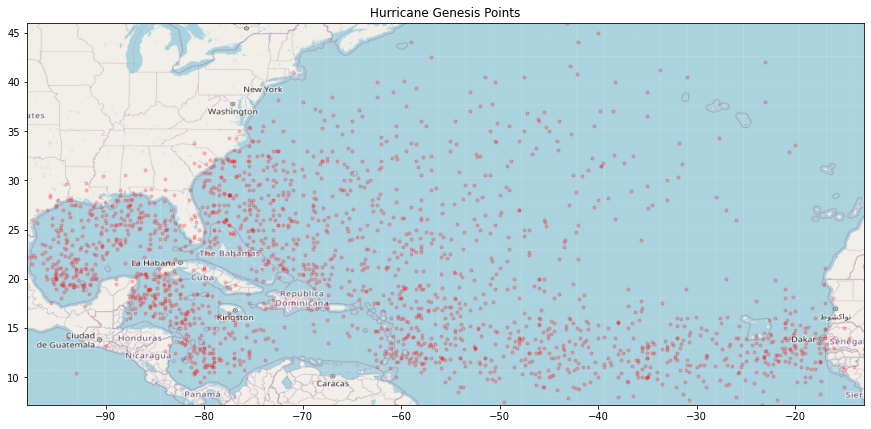

In [17]:
map_overlay = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (15,12))
ax.scatter(genesis_df.Longitude, genesis_df.Latitude, zorder=1, alpha= 0.2, c='r', s=10)
ax.set_title('Hurricane Genesis Points')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_overlay, zorder=0, extent = BBox, aspect= 'equal')

Some hurricanes are recorded as 'forming over land,' which is possible but the chances are slim to none. Hurricanes can technically form anywhere where there is a warm body of water/lots of moisture. Hurricanes that do form over land typically do not grow very big or last very long. Interesting to note that nearly all the hurricanes that have been recorded as 'forming over land' are from the earlier records (pre 1900s), according to the data. This could be perhaps due to lack of equipment/technologies to accurately record the data (For example, the lat/long data was recorded to the nearest tenth of a degree, which can cover a rather large distance).

In [18]:
'''
Same as above prep_hurricane_data but drop ID
'''
def prep_hurricane_data2(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)
    
    # Strip characters (N, E, S, W) from lat/long
    #df['Latitude'] = df['Latitude'].map(lambda x: x.rstrip('NS'))
    #df['Longitude'] = df['Longitude'].map(lambda x: x.rstrip('EW'))
    df['Latitude'] = df.apply(lambda row: float(row.Latitude.rstrip('N')) if ('N' in row.Latitude) 
                              else float(row.Latitude.rstrip('S'))*-1, axis = 1)
    df['Longitude'] = df.apply(lambda row: float(row.Longitude.rstrip('E')) if ('E' in row.Longitude) 
                              else float(row.Longitude.rstrip('W'))*-1, axis = 1)
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['ID']:
            df[column] = pd.to_numeric(df[column]) # turn every column into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column
            
    
    # standardize the variables (4)
#     tv_temp1 = df['Latitude'] # temporary variable for target variables
#     tv_temp2 = df['Longitude']
#     scaler = StandardScaler()
#     scaler.fit(df.drop(['Latitude','Longitude'], axis=1))
#     df = pd.DataFrame(scaler.transform(df.drop(['Latitude','Longitude'], axis=1)), 
#                       columns = df.drop(['Latitude','Longitude'], axis=1).columns)
#     df['Latitude'] = tv_temp1
#     df['Longitude'] = tv_temp2
    return df

In [19]:
df1 = clean_file2('hurdat2.txt')
df2 = prep_hurricane_data2(df1)
df2

,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,34NW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
0,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
1,600,0,28.0,-95.4,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
2,1200,0,28.0,-96.0,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
3,1800,0,28.1,-96.5,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
4,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,1200,0,52.2,-9.3,45,970.000000,90.000000,240.000000,120.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51836,1800,0,52.2,-8.9,40,972.000000,90.000000,240.000000,90.000000,90.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,26
51837,0,0,51.8,-8.2,40,974.000000,0.000000,210.000000,90.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27
51838,600,0,51.4,-6.0,40,976.000000,0.000000,180.000000,90.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,11,27


In [20]:
landfall_df = df2.loc[df2['Record'] == 1] # hurricanes that made landfall
landfall_df

,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,34NW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
4,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
48,2100,1,30.1,-85.7,100,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,8,23
96,1500,1,41.1,-71.7,50,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,10,19
127,600,1,30.2,-88.6,100,961.000000,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1852,8,26
163,0,1,28.0,-82.8,70,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1852,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51468,1230,1,35.2,-75.6,85,956.000000,190.000000,190.000000,150.000000,80.000000,...,120.000000,80.000000,70.000000,50.00000,60.00000,50.000000,40.000000,2019,9,6
51499,1530,1,24.2,-97.7,40,1003.000000,0.000000,0.000000,40.000000,70.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,9,4
51618,1745,1,28.9,-95.4,40,1003.000000,0.000000,40.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,9,17
51637,2200,1,18.1,-65.4,40,1004.000000,0.000000,70.000000,30.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2019,9,24


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Linear Regression on All data:

In [22]:
# LR on latitude target variable
target = 'Latitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75)

In [23]:
reg = LinearRegression()
reg.fit(X_train, y_train)

lat_pred = reg.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred)) #1 is perfect score
print(lat_pred)
print(y_test)

Mean squared error: 98.35
Coefficient of determination: 0.07
[26.90894424 20.64777068 29.41531804 ... 27.46998467 29.4537565
 25.07432258]
3120     24.2
46978    30.6
31469    10.5
41168    19.8
27215    29.9
         ... 
49350    12.4
19295    19.8
19058    30.3
40918    41.3
13918    21.4
Name: Latitude, Length: 12960, dtype: float64


In [24]:
# NEW
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV

In [25]:
# NEW
#  Ridge Hyperparameter Tuning for Latitude target variable

# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

ridge = Ridge(alpha=1).fit(X_train, y_train)
#get_cv_scores(ridge)
lat_pred_ridge = ridge.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred_ridge)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred_ridge)) #1 is perfect score

Mean squared error: 98.35
Coefficient of determination: 0.07


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.2s finished


Best Score:  0.06923966163199069
Best Params:  {'alpha': 483.6040100250626}


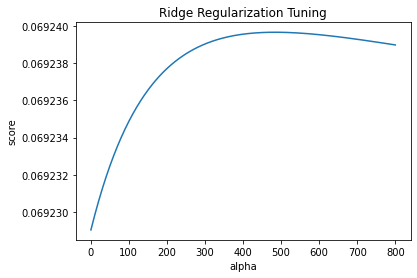

In [135]:
# NEW
# find optimal alpha with grid search

# Define function for grid search, outputs plot and best parameter.
def grid_search(est, alpha):
    param_grid = dict(alpha=alpha)
    grid = GridSearchCV(estimator=est, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    est_scores = grid_result.cv_results_['mean_test_score'].tolist()
    plt.plot(alpha,est_scores)
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Ridge Regularization Tuning')

#alpha = [0.1, 0.5, 1, 10, 100, 200, 300, 400, 2000]
alpha = np.linspace(1, 800, 400).tolist()
grid_search(ridge, alpha)

In [26]:
# LR on longitude target variable
target = 'Longitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75)

In [27]:
reg2 = LinearRegression()
reg2.fit(X_train, y_train)

long_pred = reg2.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, long_pred)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, long_pred)) #1 is perfect score
print(long_pred)
print(y_test)

Mean squared error: 376.08
Coefficient of determination: 0.09
[-64.15238193 -65.51901008 -74.27134312 ... -63.5462446  -60.28165976
 -73.78667986]
28687   -18.2
6642    -39.7
5358    -87.3
22241   -21.0
13566   -57.0
         ... 
8259    -45.5
44362   -46.0
29540   -63.6
40530   -55.1
2757    -73.0
Name: Longitude, Length: 12960, dtype: float64


In [28]:
# NEW
#  Ridge Hyperparameter Tuning for Longitude target variable

ridge = Ridge(alpha=1).fit(X_train, y_train)
#get_cv_scores(ridge)
lat_pred_ridge = ridge.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred_ridge)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred_ridge)) #1 is perfect score

Mean squared error: 376.08
Coefficient of determination: 0.09


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished


Best Score:  0.08700516632291803
Best Params:  {'alpha': 1.4000000000000001}


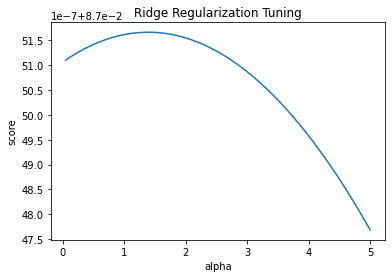

In [122]:
# NEW
# find optimal alpha with grid search
#alpha = [0.1, 0.5, 1, 10, 100, 200, 300, 400]
#alpha = np.linspace(1, 400, 400).tolist()
alpha = np.linspace(0.05, 5, 100).tolist()
grid_search(ridge, alpha)

In [29]:
df_AL1 = df2.head(5)
df_AL1

,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,34NW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
0,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
1,600,0,28.0,-95.4,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
2,1200,0,28.0,-96.0,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
3,1800,0,28.1,-96.5,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
4,2100,1,28.2,-96.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25


In [31]:
d1_lr = haversine(df_AL1['Latitude'].iloc[-1], df_AL1['Latitude'].iloc[-1], df_AL1['Longitude'].iloc[-1], long_pred[0])
d2_lr = haversine(df_AL1['Latitude'].iloc[-1], lat_pred[0], df_AL1['Longitude'].iloc[-1], df_AL1['Longitude'].iloc[-1])
print("Distance 1:", d1_lr)
print("Distance 2:", d2_lr)

#fig, axs = plt.subplots(1, 3)
plt.figure(1, figsize=(12,9))
df_AL1 = df1_1.loc[df1_1['ID'] == 'AL041992']  # Hurricane Andrew

lats = [df_AL1['Latitude'].iloc[0], df_AL1['Latitude'].iloc[-1]]
longs = [df_AL1['Longitude'].iloc[0], long_pred[0]]

#ax = utils.create_geoaxes()

#ax.plot(df_AL1['Longitude'], df_AL1['Latitude'], c='r', label='Actual Path', transform=ccrs.PlateCarree())
#ax.plot(longs, lats, label='Predicted Linear Trajectory 1 (Fixed Latitude) | {:0.3f} miles'.format(d1_lr), c='purple', transform=ccrs.PlateCarree())

lats = [df_AL1['Latitude'].iloc[0], lat_pred[0]]
longs = [df_AL1['Longitude'].iloc[0], df_AL1['Longitude'].iloc[-1]]

#ax.plot(longs, lats, label='Predicted Linear Trajectory 2 (Fixed Longitude) | {:0.3f} miles'.format(d2_lr), c='blue', transform=ccrs.PlateCarree())
#ax.plot(df_AL1['Longitude'].iloc[0], df_AL1['Latitude'].iloc[0], 'ro', transform=ccrs.PlateCarree(), label='Genesis Point')
#ax1 = plt.title('Actual Path vs Predicted (Linear) Paths of Hurricane Andrew (AL041992) for fixed Latitude/Longitude using Linear Regression')
#ax.set_xlabel('Latitude')
#ax.set_ylabel('Longitude')
#plt.legend()

#plt.show()

Distance 1: 1982.4570584432272
Distance 2: 89.23155884510238


<Figure size 864x648 with 0 Axes>

# Helper function: Haversine
Lets us calculate distance between two lat/long coordinates.

In [30]:

from math import sin, cos, sqrt, atan2, radians

def haversine(lat_1, lat_2, long_1, long_2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(long_1)
    lat2 = radians(lat_2)
    lon2 = radians(long_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c/1.60934 #Divide by 1.6 to convert from km to miles



In [32]:
print("Distance 1:", haversine(df_AL1['Latitude'].iloc[-1], df_AL1['Latitude'].iloc[-1], df_AL1['Longitude'].iloc[-1], long_pred[0]))
print("Distance 2:", haversine(df_AL1['Latitude'].iloc[-1], lat_pred[0], df_AL1['Longitude'].iloc[-1], df_AL1['Longitude'].iloc[-1]))

Distance 1: 1116.2791780329076
Distance 2: 586.860897116139


Linear Regression on Only Genesis points:

In [32]:
#genesis_df.drop('Status', 1, inplace = True)

In [33]:
genesis_df

,Time,Record,Latitude,Longitude,Wind speed,Pressure,34NE,34SE,34SW,34NW,...,50SE,50SW,50NW,64NE,64SE,64SW,64NW,Year,Month,Day
ID,,,,,,,,,,,,,,,,,,,,,
AL011851,0,0,28.0,-94.8,80,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1851,6,25
AL011852,0,0,20.5,-67.1,60,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1852,8,19
AL011853,1200,0,32.5,-69.0,50,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1853,8,5
AL011854,0,0,26.0,-92.5,60,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1854,6,25
AL011855,1200,0,22.2,-98.0,90,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1855,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL282005,0,0,13.2,-62.1,30,1007.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2005,11,14
AL291969,1200,0,10.3,-81.0,45,992.119732,83.199075,77.627768,50.983816,61.755293,...,23.816622,16.460818,19.488318,8.15101,7.75432,5.549404,6.532611,1969,11,21
AL292005,1200,0,27.0,-48.0,25,1010.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2005,11,19


In [34]:
# LR on latitude target variable
target = 'Latitude'

X = genesis_df.drop(target, 1)
Y = genesis_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75)

In [35]:
reg = LinearRegression()
reg.fit(X_train, y_train)

lat_pred = reg.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred)) #1 is perfect score

Mean squared error: 46.57
Coefficient of determination: 0.13


In [36]:
# NEW
#  Ridge Hyperparameter Tuning for Latitude target variable (genesis only)

ridge = Ridge(alpha=1).fit(X_train, y_train)
#get_cv_scores(ridge)
lat_pred_ridge = ridge.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred_ridge)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred_ridge)) #1 is perfect score

Mean squared error: 46.61
Coefficient of determination: 0.13


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2384 tasks      | elapsed:    3.3s


Best Score:  0.15895812450547359
Best Params:  {'alpha': 22603.206412825653}


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    3.5s finished


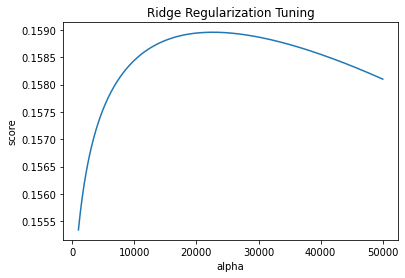

In [147]:
# NEW
# find optimal alpha with grid search
alpha = [0.1, 0.5, 1, 10, 100, 200, 300, 400, 1000, 5000, 10000, 20000, 50000]
#alpha = np.linspace(1, 400, 400).tolist()
alpha = np.linspace(1000, 50000, 500).tolist()
grid_search(ridge, alpha)

In [37]:
# LR on longitude target variable
target = 'Longitude'

X = genesis_df.drop(target, 1)
Y = genesis_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75)

In [38]:
reg = LinearRegression()
reg.fit(X_train, y_train)

long_pred = reg.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, long_pred)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, long_pred)) #1 is perfect score

Mean squared error: 385.03
Coefficient of determination: 0.15


In [39]:
# NEW
#  Ridge Hyperparameter Tuning for Longitude target variable (genesis only)

ridge = Ridge(alpha=1).fit(X_train, y_train)
#get_cv_scores(ridge)
lat_pred_ridge = ridge.predict(X_test)
print('Mean squared error: %.2f'% mean_squared_error(y_test, lat_pred_ridge)) #0 is perfect score
print('Coefficient of determination: %.2f'% r2_score(y_test, lat_pred_ridge)) #1 is perfect score

Mean squared error: 385.00
Coefficient of determination: 0.15


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Best Score:  0.1436198397444421
Best Params:  {'alpha': 2.068181818181818}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


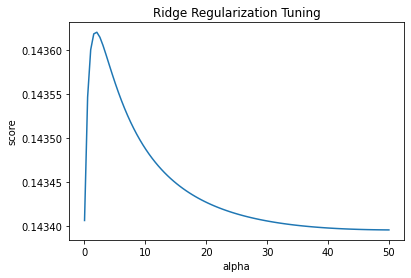

In [152]:
# NEW
# find optimal alpha with grid search
#alpha = [0.1, 0.5, 1, 10, 100, 200, 300, 400]
#alpha = np.linspace(1, 400, 400).tolist()
alpha = np.linspace(0.05, 50, 100).tolist()
grid_search(ridge, alpha)

# Random Forests

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
# RF on latitudes
target = 'Latitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75, random_state = 219)

In [42]:
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 219)

# Train the model on training data
rf.fit(X_train, y_train)

lat_pred_rf = rf.predict(X_test)

#print(lat_pred_rf)
#print(y_test)

In [43]:
# NEW - Tuning Hyperparameters
# inspect params used by random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 219,
 'verbose': 0,
 'warm_start': False}

In [44]:
# NEW
from sklearn.model_selection import RandomizedSearchCV

In [45]:
# NEW

# Generate random grid for tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(25, 250, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [46]:
# NEW
# Tune for RF latitudes
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=20, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=219),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 175, 200, 225,
                                                         250]},
                   random_state=20, verbose=2)

In [47]:
# NEW
# Tuning Results

rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [48]:
# NEW
# Grid Search CV
param_grid = {
    'bootstrap': [True],
    'max_depth': [45, 50, 55, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 145, 150, 155]
}

rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 29.2min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=219), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [45, 50, 55, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 145, 150, 155]},
             verbose=2)

In [49]:
# NEW
# Tuning Results

rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 45,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 155}

In [99]:
# NEW
# define model accuracy function

def get_accuracy(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - abs(mape)
    #print('mape = {:0.2f}%.'.format(mape))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [100]:
# NEW
# Tuning Evaluation (Compared to base RF)

# Base
print('Base Model Accuracy: %.02f'% get_accuracy(rf, X_test, y_test))
# Random Grid Tuned
print('Random Grid Tuned Model Accuracy: %.02f'% get_accuracy(rf_random, X_test, y_test))
# Grid Search CV
print('Grid Search CV Tuned Model Accuracy: %.02f'% get_accuracy(rf_grid, X_test, y_test))

Base Model Accuracy: 86.11
Random Grid Tuned Model Accuracy: 85.26
Grid Search CV Tuned Model Accuracy: 86.10


In [58]:
# RF on longitudes
target = 'Longitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75, random_state = 219)

In [53]:
# Instantiate model with 100 decision trees
rf2 = RandomForestRegressor(n_estimators = 100, random_state = 219)

# Train the model on training data
rf2.fit(X_train, y_train)

long_pred_rf = rf2.predict(X_test)

#print(long_pred_rf)
#print(y_test)

In [54]:
# NEW
# Tune for RF longitudes
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=219, n_jobs = -1)

rf2_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=219),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 175, 200, 225,
                                                         250]},
                   random_state=219, verbose=2)

In [55]:
# NEW
# Tuning Results

rf2_random.best_params_

{'n_estimators': 225,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [93]:
# NEW
# Grid Search CV
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [100, 200, 225, 250]
}

rf2_grid = GridSearchCV(estimator = rf2, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
rf2_grid.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 10.2min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=219), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100, 200, 225, 250]},
             verbose=2)

In [97]:
# NEW
# Tuning Results

rf2_grid.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 250}

In [101]:
# NEW
# Tuning Evaluation (Compared to base RF)

# Base
print('Base Model Accuracy: %.02f'% get_accuracy(rf2, X_test, y_test))
# Random Grid Tuned
print('Random Grid Tuned Model Accuracy: %.02f'% get_accuracy(rf2_random, X_test, y_test))
# Grid Search CV
print('Grid Search CV Tuned Model Accuracy: %.02f'% get_accuracy(rf2_grid, X_test, y_test))

Base Model Accuracy: -200.54
Random Grid Tuned Model Accuracy: -199.95
Grid Search CV Tuned Model Accuracy: 86.12


Distance 1: 1129.5277007623451
Distance 2: 319.24304353804337


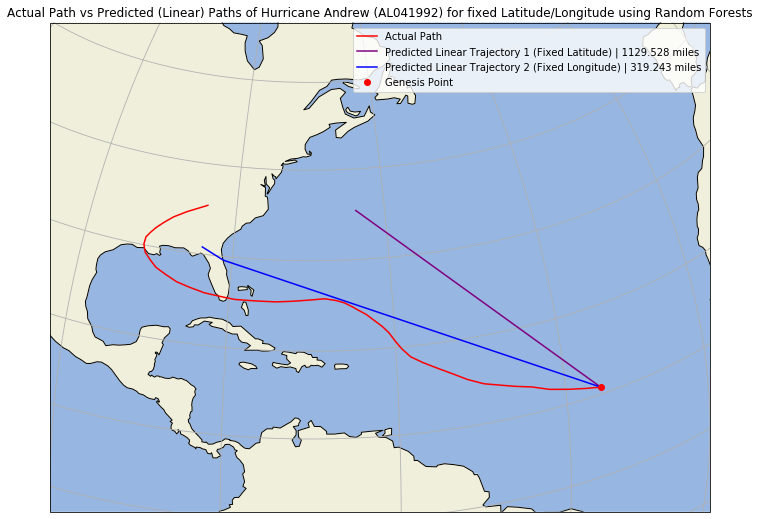

In [186]:
d1_rf = haversine(df_AL1['Latitude'].iloc[-1], df_AL1['Latitude'].iloc[-1], df_AL1['Longitude'].iloc[-1], long_pred_rf[0])
d2_rf = haversine(df_AL1['Latitude'].iloc[-1], lat_pred_rf[0], df_AL1['Longitude'].iloc[-1], df_AL1['Longitude'].iloc[-1])
print("Distance 1:", d1_rf)
print("Distance 2:", d2_rf)

plt.figure(2, figsize=(12,9))
df_AL1 = df1_1.loc[df1_1['ID'] == 'AL041992']  # Hurricane Andrew

lats = [df_AL1['Latitude'].iloc[0], df_AL1['Latitude'].iloc[-1]]
longs = [df_AL1['Longitude'].iloc[0], long_pred_rf[0]]

ax = utils.create_geoaxes()

ax.plot(df_AL1['Longitude'], df_AL1['Latitude'], c='r', label='Actual Path', transform=ccrs.PlateCarree())
ax.plot(longs, lats, label='Predicted Linear Trajectory 1 (Fixed Latitude) | {:0.3f} miles'.format(d1_rf), c='purple', transform=ccrs.PlateCarree())

lats = [df_AL1['Latitude'].iloc[0], lat_pred_rf[0]]
longs = [df_AL1['Longitude'].iloc[0], df_AL1['Longitude'].iloc[-1]]

ax.plot(longs, lats, label='Predicted Linear Trajectory 2 (Fixed Longitude) | {:0.3f} miles'.format(d2_rf), c='blue', transform=ccrs.PlateCarree())
ax.plot(df_AL1['Longitude'].iloc[0], df_AL1['Latitude'].iloc[0], 'ro', transform=ccrs.PlateCarree(), label='Genesis Point')
ax1 = plt.title('Actual Path vs Predicted (Linear) Paths of Hurricane Andrew (AL041992) for fixed Latitude/Longitude using Random Forests')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.legend()

plt.show()

Distance 1: 1129.5277007623451
Distance 2: 319.24304353804337


# Gradient Boosting Regression

In [102]:
from sklearn import ensemble

In [105]:
# GBF on latitudes
target = 'Latitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75, random_state = 219)

In [106]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

gbf = ensemble.GradientBoostingRegressor(**params, random_state = 219)
gbf.fit(X_train, y_train)

lat_pred_gbf = gbf.predict(X_test)

In [109]:
gbf.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'ls',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 219,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [110]:
# NEW
# Grid Search CV
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1]
}

gbf_grid = GridSearchCV(estimator = gbf, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
gbf_grid.fit(X_train, y_train)
gbf_grid.best_params_

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 29.5min finished


{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_split': 4,
 'n_estimators': 500}

In [111]:
# NEW
# Tuning Evaluation (Compared to base RF)

# Base
print('Base Model Accuracy: %.02f'% get_accuracy(gbf, X_test, y_test))
# Grid Search CV
print('Grid Search CV Tuned Model Accuracy: %.02f'% get_accuracy(gbf_grid, X_test, y_test))

Base Model Accuracy: 68.99
Grid Search CV Tuned Model Accuracy: 76.98


In [113]:
# GBF on longitudes
target = 'Longitude'

X = df2.drop(target, 1)
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.75, random_state = 219)

In [114]:
gbf2 = ensemble.GradientBoostingRegressor(**params, random_state = 219)
gbf2.fit(X_train, y_train)

long_pred_gbf = gbf2.predict(X_test)

In [115]:
# NEW
# Grid Search CV
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1]
}

gbf2_grid = GridSearchCV(estimator = gbf2, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
gbf2_grid.fit(X_train, y_train)
gbf2_grid.best_params_

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 29.7min finished


{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_split': 3,
 'n_estimators': 500}

In [116]:
# NEW
# Tuning Evaluation (Compared to base RF)

# Base
print('Base Model Accuracy: %.02f'% get_accuracy(gbf2, X_test, y_test))
# Grid Search CV
print('Grid Search CV Tuned Model Accuracy: %.02f'% get_accuracy(gbf2_grid, X_test, y_test))

Base Model Accuracy: -inf
Grid Search CV Tuned Model Accuracy: -inf


Distance 1: 1145.043542346828
Distance 2: 411.01846551249645


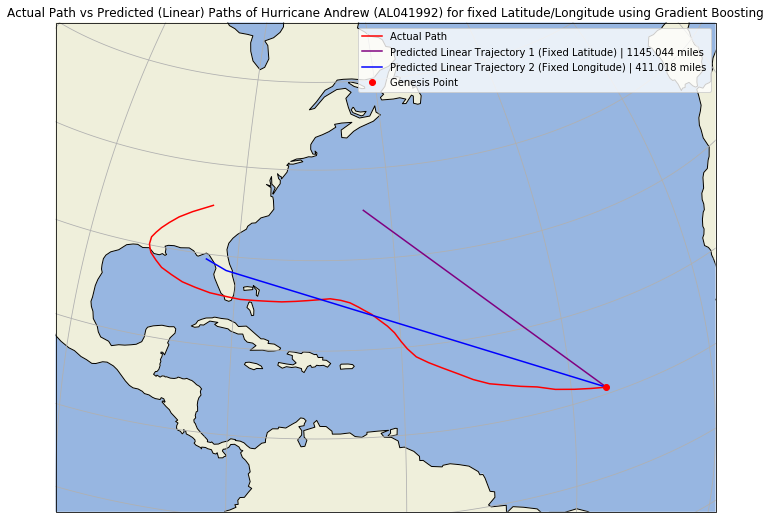

In [192]:
d1_gbf = haversine(df_AL1['Latitude'].iloc[-1], df_AL1['Latitude'].iloc[-1], df_AL1['Longitude'].iloc[-1], long_pred_gbf[0])
d2_gbf = haversine(df_AL1['Latitude'].iloc[-1], lat_pred_gbf[0], df_AL1['Longitude'].iloc[-1], df_AL1['Longitude'].iloc[-1])
print("Distance 1:", d1_gbf)
print("Distance 2:", d2_gbf)

plt.figure(3, figsize=(12,9))
df_AL1 = df1_1.loc[df1_1['ID'] == 'AL041992']  # Hurricane Andrew

lats = [df_AL1['Latitude'].iloc[0], df_AL1['Latitude'].iloc[-1]]
longs = [df_AL1['Longitude'].iloc[0], long_pred_gbf[0]]

ax = utils.create_geoaxes()

ax.plot(df_AL1['Longitude'], df_AL1['Latitude'], c='r', label='Actual Path', transform=ccrs.PlateCarree())
ax.plot(longs, lats, label='Predicted Linear Trajectory 1 (Fixed Latitude) | {:0.3f} miles'.format(d1_gbf), c='purple', transform=ccrs.PlateCarree())

lats = [df_AL1['Latitude'].iloc[0], lat_pred_gbf[0]]
longs = [df_AL1['Longitude'].iloc[0], df_AL1['Longitude'].iloc[-1]]

ax.plot(longs, lats, label='Predicted Linear Trajectory 2 (Fixed Longitude) | {:0.3f} miles'.format(d2_gbf), c='blue', transform=ccrs.PlateCarree())
ax.plot(df_AL1['Longitude'].iloc[0], df_AL1['Latitude'].iloc[0], 'ro', transform=ccrs.PlateCarree(), label='Genesis Point')
ax1 = plt.title('Actual Path vs Predicted (Linear) Paths of Hurricane Andrew (AL041992) for fixed Latitude/Longitude using Gradient Boosting')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.legend()

plt.show()

Distance 1: 1145.043542346828
Distance 2: 411.01846551249645


# Clustering + LSTM

In [88]:
import matplotlib.path as pltPath

In [119]:
# Convert Lat/long to cartesian coordinates
def FeatureColumnsXYZ(dframe):
    dframe['x'] = np.cos(np.radians(dframe.Latitude)) * np.cos(np.radians(dframe.Longitude))
    dframe['y'] = np.cos(np.radians(dframe.Latitude)) * np.sin(np.radians(dframe.Longitude))
    dframe['z'] = np.sin(np.radians(dframe.Latitude))
    
    dframe['xLag1'] = np.cos(np.radians(dframe.LatLag1)) * np.cos(np.radians(dframe.LonLag1))
    dframe['yLag1'] = np.cos(np.radians(dframe.LatLag1)) * np.sin(np.radians(dframe.LonLag1))
    dframe['zLag1'] = np.sin(np.radians(dframe.LatLag1))

In [120]:
df_xyz = FeatureColumnsXYZ(df1_1)

AttributeError: 'DataFrame' object has no attribute 'LatLag1'

In [106]:
#Clustering
def FeatureColumns(dframe):
    global train_df
    
    grid1 = [(-70.0,5.0),(-70.0,20.0),(-10.0,20.0),(-10.0,5.0),(-70.0,5.0)]
    grid2 = [(-100.0,5.0),(-100.0,20.0),(-70.0,20.0),(-70.0,5.0),(-100.0,5.0)]
    grid3 = [(-70.0,20.0),(-70.0,40.0),(-10.0,40.0),(-10.0,20.0),(-70.0,20.0)]
    grid4 = [(-100.0,20.0),(-100.0,40.0),(-70.0,40.0),(-70.0,20.0),(-100.0,20.0)]
    poly1 = pltPath.Path(grid1)
    poly2 = pltPath.Path(grid2)
    poly3 = pltPath.Path(grid3)
    poly4 = pltPath.Path(grid4)
    
    Genesis = dframe.groupby('ID').first()
    Genesis['GroupID'] = 0
    
    for row in range(0,Genesis.shape[0]):
        point = ([Genesis.Longitude[row], Genesis.Latitude[row]])
        inside1 = poly1.contains_point(point)
        inside2 = poly2.contains_point(point)
        inside3 = poly3.contains_point(point)
        inside4 = poly4.contains_point(point)
        if inside1:
            Genesis.GroupID.iloc[row] = 1
        if inside2:       
            Genesis.GroupID.iloc[row] = 2
        if inside3:
            Genesis.GroupID.iloc[row] = 3
        elif inside4:
            Genesis.GroupID.iloc[row] = 4
    
    train_events_g1 = Genesis[Genesis.GroupID == 1].index.values.tolist()
    train_events_g2 = Genesis[Genesis.GroupID == 2].index.values.tolist()
    train_events_g3 = Genesis[Genesis.GroupID == 3].index.values.tolist()
    train_events_g4 = Genesis[Genesis.GroupID == 4].index.values.tolist()
    
    dframe['GroupID'] = 0
    dframe.GroupID.loc[dframe.ID.isin(train_events_g1)] = 1
    dframe.GroupID.loc[dframe.ID.isin(train_events_g2)] = 2
    dframe.GroupID.loc[dframe.ID.isin(train_events_g3)] = 3
    dframe.GroupID.loc[dframe.ID.isin(train_events_g4)] = 4

    one_hot = pd.get_dummies(dframe['GroupID'],prefix='Region')
    train_df = train_df.join(one_hot)

In [116]:
genesis_coords = df1_1[['ID','Latitude','Longitude']].groupby('ID').first()
FeatureColumns(df1_1)

ValueError: columns overlap but no suffix specified: Index(['Region_0', 'Region_1', 'Region_2', 'Region_3', 'Region_4'], dtype='object')

In [96]:
# LSTM model
def model_def(data):
    model = Sequential()
    init = RandomUniform(minval=-0.001, maxval=0.001)
    model.add(LSTM(50,input_shape=(None, data.shape[2]), kernel_initializer=init, return_sequences=True))
    model.add(LSTM(10,input_shape=(None, data.shape[2]), kernel_initializer=init, return_sequences=True))
    model.add(Dense(6, kernel_initializer=init))
    model.add(Dense(3, activation='linear', kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc','mae'])
    return model

def train_on_batch_lstm(data,train_df,NumEpochs):
    model_batch_train = model_def(data)
    for i in range(NumEpochs):
        print ('Running Epoch No: ', i)
        for stormID, data in train_df.groupby('StormID'):
            train = data[['x','y','z','Region_1','Region_2','Region_3','Region_4','S1','S2','S3','S4','S5','S6','S1E', 'S2E', 'S3E', 'S4E', 'S5E', 'S6E','xLag1','yLag1','zLag1']].values
            x_train = np.expand_dims(train[:,:-3], axis=0)
            y_train = np.expand_dims(train[:,-3:], axis=0)
            model_batch_train.train_on_batch(x_train,y_train)
            model_batch_train.reset_states()
    return model_batch_train
  
models = []
for ens in range(ensemble_size):
    lstm_model = train_on_batch_lstm(data,train_df, nb_epoch)
    # serialize model to JSON
    model_json = lstm_model.to_json()
    with open("gmodel_"+str(ens)+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    lstm_model.save_weights("gmodel_"+str(ens)+".h5")
    models.append("gmodel_"+str(ens)+".h5")
    print("Saved model to disk")

NameError: name 'ensemble_size' is not defined

In [ ]:
# Predicting with LSTM
def PredictHist(key,value,AndTest,models,ensemble_size,NoOfSimPoints):
    SimPath = pd.DataFrame(columns=['Sim','Epoch','Lon','Lat'])
    SimPath['Sim'] = np.repeat(np.arange(ensemble_size),NoOfSimPoints)
    SimPath['Epoch'] = list(np.arange(NoOfSimPoints))*ensemble_size
    SimPath.set_index(['Sim', 'Epoch'],inplace=True)
    
    # Separate the Inputs and Targets
    x_AndTest_full = AndTest[['x','y','z','Region_1','Region_2','Region_3','Region_4','S1','S2','S3','S4','S5','S6','S1E', 'S2E', 'S3E', 'S4E', 'S5E', 'S6E']].values
    y_AndTest_full = AndTest[['xLag1','yLag1','zLag1']].values

    ## data has to be reshaped by (nb_samples,timesteps,NoOfAttributes)
    AndTest_data = x_AndTest_full.reshape(x_AndTest_full.shape[0], 1, x_AndTest_full.shape[1])
    AndTest_target = y_AndTest_full.reshape(y_AndTest_full.shape[0], 1, y_AndTest_full.shape[1])
    
    end = NoOfSimPoints
    
    simval = 0
    for sim,mod in enumerate(models):
        print ('model = ',mod)
        pred_model = model_def(AndTest_data)
        pred_model.load_weights(mod)
        
        # Use the fitted model to make predictions on the test data
        predictions_And_feedback = np.empty((0,3))
        X = AndTest_data[0,0,:]
        Y = AndTest_data[0,0,3:7]
        predictions_And_feedback = np.vstack((predictions_And_feedback,AndTest_data[0,0,0:3]))
        for i in range(NoOfSimPoints-1): 
            yhat = forecast_lstm(pred_model, 1, X)
            Lon_temp = np.degrees(np.arctan2(yhat[0][1],yhat[0][0]))
            Lat_temp = np.degrees(np.arcsin(yhat[0][2]))
            
            GridIdx = gridpts_tree.query([(Lon_temp*1.0,Lat_temp)])[1]
            x_coord = Grid.iloc[GridIdx]['Lon'].values[0]
            y_coord = Grid.iloc[GridIdx]['Lat'].values[0]
            temp = [(0,-1),(-1,-1),(-1,0),(-1,1),(0,1),(1,1)]
            prob = []
            for x, y in [(x_coord+i*0.5, y_coord+j*0.5) for i, j in temp]:
                temp = '('+str(x)+', '+str(y)+')'
                MatchGrid = Grid[Grid.Cell.astype(str).str.contains(temp)]
                if (MatchGrid.shape[0] == 1):
                    prob.append(MatchGrid.CountHits.values.tolist()[0])
                else:
                    prob.append(0)
            if sum(prob) > 0:
                b = [temp/sum(prob) for temp in prob]
            else:
                b = prob
            
            k = np.array(b).reshape(1,6)
            kk = np.zeros((1,6),dtype=int)

            indices = np.where(k == k.max())
            kk[0,indices[1]]=1
            
            predictions_And_feedback = np.vstack((predictions_And_feedback,yhat))
            pred_model.reset_states()

            X = np.hstack((yhat[0],Y,k[0],kk[0]))
        
        SimPath.Lon.loc[pd.IndexSlice[simval,:]] = np.degrees(np.arctan2(predictions_And_feedback[:,1],predictions_And_feedback[:,0]))
        SimPath.Lat.loc[pd.IndexSlice[simval,:]] = np.degrees(np.arcsin(predictions_And_feedback[:,2]))
        end = end+NoOfSimPoints
        simval = simval+1
    SimPath.to_csv(key+'_Pred.csv')
    AndTest.to_csv(key+'_Actual.csv')
    return SimPath
  
TestHist = {'Ivan2004':'AL092004','Wilma2005':'AL252005'}

def PlotStochTrack(HistPath, StochPath, plt_title):
    m1 = MapTemplate(plt_title)
    for stormid, track in HistPath.groupby('StormID'):
        lat_kat = track.Lat.values
        lon_kat = track.Lon.values
        x1, y1 = m1(lon_kat,lat_kat)
        plt.plot(x1,y1,'-',label=stormid,linewidth=2,color='black')
    
    for stormid, track in StochPath.groupby('Sim'):
        lat_kat = track.Lat.values
        lon_kat = track.Lon.values
        poly = np.polyfit(list(lon_kat), list(lat_kat), 5)
        poly_lat = np.poly1d(poly)(lon_kat)
        poly_lat[0] = lat_kat[0]
        x1, y1 = m1(lon_kat,lat_kat)
        plt.plot(x1,y1,'-',label=stormid,linewidth=2)
    plt.legend()

for key, value in TestHist.items():
    HistPath = test_df[test_df.StormID == value]
    SimPath = PredictHist(key,value,HistPath,models,ensemble_size,NoOfSimPoints)
    PlotStochTrack(HistPath, SimPath, key)